In [1]:
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import DenseNet121

import numpy as np


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
train_dir = '/data/user/home/ppati15/AffectNet/train_class'
val_dir = '/data/user/home/ppati15/AffectNet/val_class'

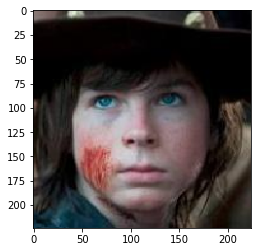

In [5]:
def get_image(filename):
    ########################################################################
    # TODO: Your code here...
    ########################################################################
    image = load_img(filename, target_size=(224, 224))
    np_image = img_to_array(image)
    return np_image


import matplotlib.pyplot as plt
%matplotlib inline

image = get_image('/data/user/home/ppati15/AffectNet/train_class/class001/image0000002.jpg')
plt.imshow(np.uint8(image))
plt.show()

In [6]:
train_data_gen= ImageDataGenerator(rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
validation_data_gen=ImageDataGenerator(rescale=1./255)

In [7]:
# # train and validation directory
# train_dir="./affectnet/train_class"
# val_dir="./affectnet/val_class"

In [8]:
bs=64
cm="categorical"

train_gen=train_data_gen.flow_from_directory(train_dir,target_size=(224,224),batch_size=bs,class_mode=cm)
val_gen=validation_data_gen.flow_from_directory(val_dir,target_size=(224,224),batch_size=bs,class_mode=cm)

Found 15000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [9]:
def create_model(opt, input_tensor, kernel_initializer='he_normal', trained_layers=15):
    model_densenet= DenseNet121(include_top=False, weights='imagenet', input_tensor=input_tensor)
    
    top_model = Sequential()
    top_model.add(Flatten())
    top_model.add(Dense(512, activation='relu',kernel_initializer=kernel_initializer))
    top_model.add(BatchNormalization())
    top_model.add(Dropout(0.2))    
   # top_model.add(Dense(128, activation='relu'))
    #top_model.add(BatchNormalization())
    #top_model.add(Dropout(0.2))
    top_model.add(Dense(3, activation='softmax'))   # 7 classes

    # Connect vgg16 and top_model
    model = Model(inputs = model_densenet.input, outputs = top_model(model_densenet.output))

    fixed_layers = -1 * trained_layers
    # Fix layers
    for layer in model.layers[:fixed_layers]:
        layer.trainable = False
    

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    #model.summary()
    
    return model

In [10]:
def create_model_no_initializer(opt, input_tensor, trained_layers=15):
    model_densenet= DenseNet121(include_top=False, weights='imagenet', input_tensor=input_tensor)
    
    top_model = Sequential()
    top_model.add(Flatten())
    top_model.add(Dense(512, activation='relu'))
    top_model.add(BatchNormalization())
    top_model.add(Dropout(0.2))    
   # top_model.add(Dense(128, activation='relu'))
    #top_model.add(BatchNormalization())
    #top_model.add(Dropout(0.2))
    top_model.add(Dense(3, activation='softmax'))   # 7 classes

    # Connect vgg16 and top_model
    model = Model(inputs = model_densenet.input, outputs = top_model(model_densenet.output))

    fixed_layers = -1 * trained_layers
    # Fix layers
    for layer in model.layers[:fixed_layers]:
        layer.trainable = False
    

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    #model.summary()
    
    return model

In [11]:
def fit_model(model,bs,epoch,model_name):
    no_train_img=15000
    no_val_img=1500
    epochs=epoch
    batch_size=bs

    #early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
    #early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)

    h=model.fit(
           train_gen,
            steps_per_epoch=no_train_img // batch_size,
            epochs=epochs,
            validation_data=val_gen,
            validation_steps=no_val_img // batch_size,
            #callbacks=[early_stop],
             verbose=1
            )
    model.save(model_name)
    
    return h

Epoch 1/10
234/234 [==============================] - 491s 2s/step - loss: 0.9308 - accuracy: 0.6092 - val_loss: 0.7754 - val_accuracy: 0.6739
Epoch 2/10
234/234 [==============================] - 477s 2s/step - loss: 0.6796 - accuracy: 0.6944 - val_loss: 0.5932 - val_accuracy: 0.7351
Epoch 3/10
234/234 [==============================] - 482s 2s/step - loss: 0.6299 - accuracy: 0.7218 - val_loss: 0.5917 - val_accuracy: 0.7378
Epoch 4/10
234/234 [==============================] - 472s 2s/step - loss: 0.5935 - accuracy: 0.7388 - val_loss: 0.8286 - val_accuracy: 0.6508
Epoch 5/10
234/234 [==============================] - 477s 2s/step - loss: 0.5748 - accuracy: 0.7500 - val_loss: 0.6639 - val_accuracy: 0.7024
Epoch 6/10
234/234 [==============================] - 471s 2s/step - loss: 0.5627 - accuracy: 0.7560 - val_loss: 0.6520 - val_accuracy: 0.7412
Epoch 7/10
234/234 [==============================] - 476s 2s/step - loss: 0.5400 - accuracy: 0.7637 - val_loss: 0.5855 - val_accuracy: 0.7649

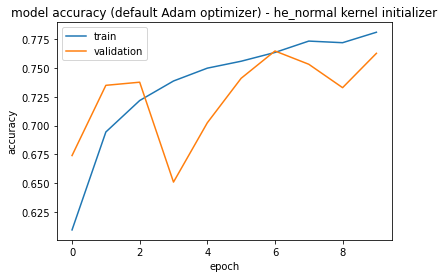

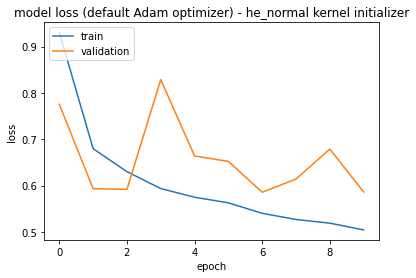

In [12]:
# he_normal
input_tensor=Input(shape=(224,224,3))
lr=0.001
opt = keras.optimizers.Adam(lr) 
model_name = 'densenet_default_he_normal_0.001'
model=create_model(opt,input_tensor)
h=fit_model(model, bs, 10, model_name)

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy (default Adam optimizer) - he_normal kernel initializer',)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss (default Adam optimizer) - he_normal kernel initializer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
# no initializer
input_tensor=Input(shape=(224,224,3))
lr=0.001
opt = keras.optimizers.Adam(lr) 
model_name = 'densenet_default_no_initializer_0.001'
model=create_model_no_initializer(opt,input_tensor)
h=fit_model(model, bs, 10, model_name)

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy (default Adam optimizer) - no kernel initializer',)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss (default Adam optimizer) - no kernel initializer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
234/234 [==============================] - 490s 2s/step - loss: 0.9395 - accuracy: 0.6072 - val_loss: 0.7069 - val_accuracy: 0.6787
Epoch 2/10
174/234 [=====================>........] - ETA: 1:54 - loss: 0.6926 - accuracy: 0.6871

KeyboardInterrupt: 

In [16]:
!pip install scikit-learn

     |████████████████████████████████| 26.7 MB 3.8 MB/s eta 0:00:0100:05/s eta 0:00:04██████████████████████▍         | 18.7 MB 3.8 MB/s eta 0:00:03MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 95.0 MB/s eta 0:00:01


In [72]:
#Plot the confusion matrix. Set Normalize = True/False
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))

    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names

#shuffle=False

# target_names = []
# for key in train_gen.class_indices:
#     target_names.append(key)

# print(target_names)

#Confution Matrix 

# print('Confusion Matrix')
# cm = confusion_matrix(val_gen.classes, y_pred)
# plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# print(Y_pred.shape)
# y_pred = np.argmax(Y_pred, axis=1)

# #Print Classification Report
# print('Classification Report')
# print(classification_report(val_gen.classes, y_pred, target_names=target_names))



In [39]:
def predict(model,filename):
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
   
     # reshape data for the model
    inputs = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # predict the probability across all output classes
    yhat = model.predict(inputs )
    print(yhat)

    print(np.argmax(yhat))
    
    if ((np.argmax(yhat))==0):
        print("Neutral")
    if ((np.argmax(yhat))==1):
        print("Happy")
    if ((np.argmax(yhat))==2):
         print("Sad")
    
    
    plt.imshow(np.uint8(image))
    plt.show()

In [79]:
predictions = model.predict(val_gen,steps=1500//62,verbose=3)


In [80]:
predictions.shape

(1500, 3)

['class001', 'class002', 'class003']
(1564, 3)
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

    class001       0.31      0.25      0.27       500
    class002       0.33      0.26      0.29       500
    class003       0.32      0.45      0.38       500

    accuracy                           0.32      1500
   macro avg       0.32      0.32      0.31      1500
weighted avg       0.32      0.32      0.31      1500



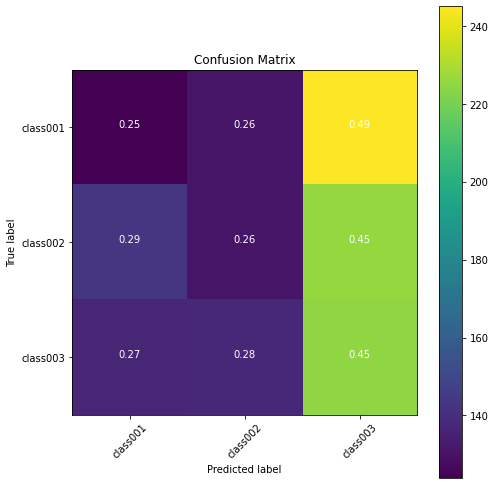

In [82]:
target_names = []
for key in train_gen.class_indices:
    target_names.append(key)

print(target_names)

 



print(Y_pred.shape)
y_pred = np.argmax(predictions, axis=1)

#Confution Matrix
print('Confusion Matrix')
cm = confusion_matrix(val_gen.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(val_gen.classes, y_pred, target_names=target_names))

In [42]:
true_label=np.zeros((1436,3))
print(true_label[i].shape)

(3,)


In [43]:
test_labels = []

for i in range(0,int(1500//64)):
    test_labels.extend(np.array(val_gen[i][1]))

    

In [44]:
test_labels[0]

array([0., 0., 1.], dtype=float32)

In [45]:
true_label=np.zeros((1436,3))
for i in range(1436):
    true_label[i]=test_labels[i]
print(true_label.shape, test_labels[1].shape, true_label[1])

(1436, 3) (3,) [0. 0. 1.]


In [46]:
# for i in range(5):
#     print(true_label[i])
# print(true_label[64])

[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]


In [64]:
# #sanity check
# x,y= val_gen[0]
# print(y)

In [65]:
true_label=true_label
predictions = predictions
true_label.shape

(1436, 3)

In [66]:
i=0
y_true=[]
y_pred=[]
while i!=1436:
    y_true.append(np.argmax(true_label[i]))
    y_pred.append(np.argmax(predictions[i]))
    i=i+1
print(len(y_true), len(y_pred))

1436 1436


In [76]:
print(y_true[:20])
print(y_pred[:20])

[2, 2, 2, 2, 1, 0, 2, 1, 1, 0, 1, 0, 2, 1, 1, 2, 0, 1, 2, 2]
[0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2]


In [77]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

print(classification_report(y_true, y_pred, target_names=val_gen.class_indices))
         

              precision    recall  f1-score   support

    class001       0.35      0.30      0.33       479
    class002       0.35      0.28      0.32       472
    class003       0.35      0.47      0.40       485

    accuracy                           0.35      1436
   macro avg       0.35      0.35      0.35      1436
weighted avg       0.35      0.35      0.35      1436



Confusion Matrix
Normalized confusion matrix


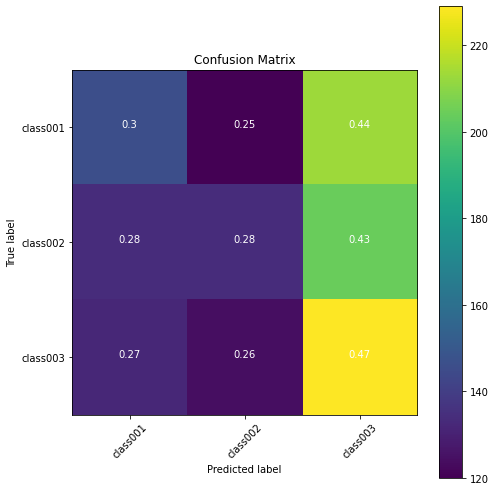

In [78]:
#Confution Matrix 

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
